#Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Import whole database
with open('feature_database.json') as json_database:
    database = json.load(json_database)

#Data Formatting

##Economy

In [3]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2005-01-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02-01,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03-01,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04-01,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05-01,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


In [4]:
X_eco_raw['date'] = X_eco_raw.index
X_eco_raw.date = pd.to_datetime(X_eco_raw.date).dt.to_period('m')
X_eco_raw.index = X_eco_raw.date
X_eco_raw = X_eco_raw.drop('date', axis=1)
X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
date,,,,,,,,,,,,
2005-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


##Mobility

In [5]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1, join="inner")

X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
2011-01-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02-01,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03-01,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04-01,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05-01,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


In [6]:
X_mob_raw['date'] = X_mob_raw.index
X_mob_raw.date = pd.to_datetime(X_mob_raw.date).dt.to_period('m')
X_mob_raw.index = X_mob_raw.date
X_mob_raw = X_mob_raw.drop('date', axis=1)
X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
date,,,,,,,,,,,,,,,,,,,
2011-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


##Energy and households

In [7]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1, join="inner")

X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
2007-03-01,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04-01,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05-01,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06-01,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07-01,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


In [8]:
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)
X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
date,,,,,,,,,
2007-03,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


##Target Values

In [9]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
1990-01-01,59.831181,11.965386,32.015404,103.811971
1990-02-01,57.338215,12.509267,31.287781,101.135264
1990-03-01,52.352284,13.325089,30.560158,96.237531
1990-04-01,49.859318,14.004941,29.104913,92.969171
1990-05-01,44.873386,14.276881,27.649667,86.799934


In [10]:
Y_raw['date'] = Y_raw.index
Y_raw.date = pd.to_datetime(Y_raw.date).dt.to_period('m')
#Y_raw.to_timestamp('m')
Y_raw.index = Y_raw.date
Y_raw = Y_raw.drop('date', axis=1)
Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
date,,,,
1990-01,59.831181,11.965386,32.015404,103.811971
1990-02,57.338215,12.509267,31.287781,101.135264
1990-03,52.352284,13.325089,30.560158,96.237531
1990-04,49.859318,14.004941,29.104913,92.969171
1990-05,44.873386,14.276881,27.649667,86.799934


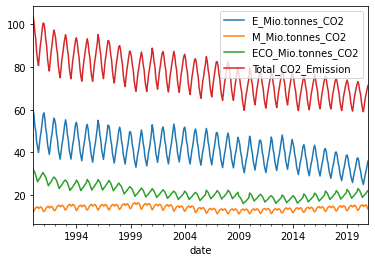

In [11]:
Y_raw.plot()

#Model Functions

##Model 1: Linear Regression

In [12]:
def my_LinearRegression(x,y,x_future,degree):
  poly = PolynomialFeatures(degree=1)
  X_train = poly.fit_transform(x)

  ### Scaling
  scaler = StandardScaler()
  #scaler = RobustScaler()
  #scaler = MinMaxScaler()

  # PCA
  pca = PCA()

  ### Validation
  cval = LeaveOneOut() 
  #cval = KFold(n_splits=2)

  ### Estimator
  estimator = LinearRegression()

  pipe = Pipeline(steps=[('scaler',scaler),('pca', pca), ('estimator', estimator)])
  param_grid = {'pca__n_components': range(1,X_train.shape[1]+1)}

  ### GridSearch
  search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
  search.fit(X_train, y)
  print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
  print(search.best_params_)

  plt.figure()
  plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'])
  #plt.plot(range(1,X_train.shape[1]+1),-search.cv_results_['mean_train_score'])
  plt.xticks(range(1,X_train.shape[1]+1))
  plt.xlabel("number of principle components")
  plt.ylabel("CV result score")
  plt.title("Grid search results for PCA components")
  plt.show()

  best_estimator = search.best_estimator_
  y_pred_train = best_estimator.predict(X_train)

  print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
  print("R2 training fit: %.03f " %r2_score(y,y_pred_train))
  #print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
  #print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

  # predicted/actual plot for test set
  ax = sns.jointplot(x=y_pred_train,y=y)
  ax.ax_joint.set_xlabel('Prediction')
  ax.ax_joint.set_ylabel('True')
  plt.show()

  y_pred_future = best_estimator.predict(poly.fit_transform(x_future))
  return y_pred_future

##Model 2: Neuronal Network

In [13]:
def my_NeuronalNetwork(x,y,x_future):
  scaler = MinMaxScaler()
  scaler.fit(x)
  x_scaled = scaler.transform(x)

  X_train, X_val, Y_train, Y_val = train_test_split(x_scaled, y, test_size=.2)

  network = models.Sequential()
  network.add(layers.Dense(2, activation='relu', input_shape=(len(X_train[0]),)))
  #network.add(layers.Dense(2, activation='relu'))
  network.add(layers.Dense(1))
  network.summary()

  network.compile(optimizer=optimizers.RMSprop(lr=0.01),
              loss='mean_squared_error',
              metrics=['mse'])
  
  history = network.fit(X_train, Y_train, batch_size=5, epochs=200, validation_data=(X_val,Y_val))

  mse = history.history['mse'] #TO DO: take from the history dictionary of the model the training accuracy
  val_mse =  history.history['val_mse'] #TO DO: take from the history dictionary of the model the validation accuracy
  loss =  history.history['loss'] #TO DO: take from the history dictionary of the model the training loss
  val_loss =  history.history['val_loss'] #TO DO: take from the history dictionary of the model the validation loss 

  epochs = range(1, len(mse) + 1)

  # Plot the Loss
  plt.plot(loss)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'b', label='Training loss') 
  # b is for "solid blue line"
  plt.plot(epochs,  val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  y_pred_train = network.predict(x_scaled)
  ax = sns.jointplot(x=y_pred_train,y=y)
  ax.ax_joint.set_xlabel('Prediction')
  ax.ax_joint.set_ylabel('True')
  plt.show()

  x_future_scaled = scaler.transform(x_future)
  y_pred_future = network.predict(x_future_scaled)

  return y_pred_future

##Model 3: PLSR

In [14]:
def my_PLSR(x,y,x_future):
  scaler = StandardScaler()
  cval = KFold(n_splits=10)
  plsr = PLSRegression()
  ct = ColumnTransformer([('scaler', scaler, np.arange(0,8))],remainder='passthrough')

  pipe = Pipeline(steps=[('scaler',ct), ('plsr', plsr)])
  param_grid = {'plsr__n_components': range(1,x.shape[1]+1)}

  search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
  search.fit(x, y)
  print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
  print(search.best_params_)

  plt.figure()
  plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
  plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
  plt.legend()
  plt.xticks(range(1,x.shape[1]+1))
  plt.xlabel("number of principle components")
  plt.title("Grid search results for PCA components")
  plt.show()

  best_estimator = search.best_estimator_
  y_pred_train = best_estimator.predict(x)

  print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
  print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

  ax = sns.jointplot(x=y_pred_train,y=y)
  ax.ax_joint.set_xlabel('Prediction')
  ax.ax_joint.set_ylabel('True')
  plt.show()

  y_pred_future = best_estimator.predict(x_future)
  return y_pred_future

##Model 4: LASSO

In [15]:
def my_LASSO(x,y,x_future,alphas):
  scaler = StandardScaler()
  scaler.fit(x)
  x_scaled = scaler.transform(x)

  cval = KFold(n_splits=10)
  lsso = Lasso()

  tuned_parameters = [{'alpha': alphas}]

  search = GridSearchCV(lsso, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
  search.fit(x_scaled, y)
  print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
  print(search.best_params_)

  plt.figure()
  plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
  plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
  plt.legend()
  plt.xticks(alphas)
  plt.xlabel("alpha")
  plt.ylabel("CV result score")
  plt.title("Grid search results for alpha")
  plt.show()

  best_estimator = search.best_estimator_
  y_pred_train = best_estimator.predict(x_scaled)


  print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
  print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

  ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
  ax.ax_joint.set_xlabel('Prediction')
  ax.ax_joint.set_ylabel('True')
  plt.show()

  x_future_scaled = scaler.transform(x_future)
  y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)
  return y_pred_future

##Model 5: Ridge

In [16]:
def my_Ridge(x,y,x_future,alphas):
  scaler = StandardScaler()
  scaler.fit(x)
  x_scaled = scaler.transform(x)

  cval = KFold(n_splits=10)
  rdge = Ridge()


  tuned_parameters = [{'alpha': alphas}]

  search = GridSearchCV(rdge, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
  search.fit(x_scaled, y)
  print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
  print(search.best_params_)

  plt.figure()
  plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
  plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
  plt.legend()
  plt.xticks(alphas)
  plt.xlabel("alpha")
  plt.ylabel("CV result score")
  plt.title("Grid search results for alpha")
  plt.show()

  best_estimator = search.best_estimator_
  y_pred_train = best_estimator.predict(x_scaled)

  print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
  print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

  ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
  ax.ax_joint.set_xlabel('Prediction')
  ax.ax_joint.set_ylabel('True')
  plt.show()

  x_future_scaled = scaler.transform(x_future)
  y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)
  return y_pred_future

#Mapping

In [17]:
Y = Y_raw[(Y_raw.index.year <= 2017)]
Y_oeko_estimate = Y_raw[(Y_raw.index.year > 2017)]

##Economy

In [18]:
Y_eco_train = Y[['ECO_Mio.tonnes_CO2']][(Y.index >= X_eco_raw.index.min())]

X_eco_train = X_eco_raw[(X_eco_raw.index.year <=2017)]
X_eco_future = X_eco_raw[(X_eco_raw.index.year >2017)]

Y_oeko_eco_estimate = Y_oeko_estimate[['ECO_Mio.tonnes_CO2']][(Y_oeko_estimate.index <= X_eco_future.index.max())]

###Model 1: Linear/Non-Linear Regression

Best parameter RMSE=0.837):
{'pca__n_components': 12}


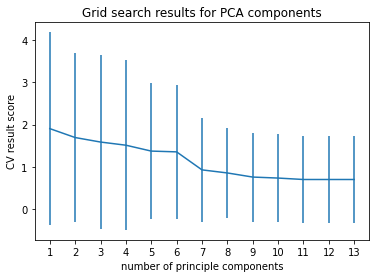

RMSE training fit: 0.772
R2 training fit: 0.709 


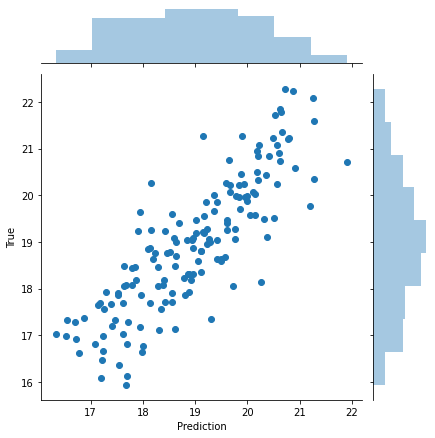

In [19]:
Y_eco_pred_future=my_LinearRegression(X_eco_train,Y_eco_train,X_eco_future,2)

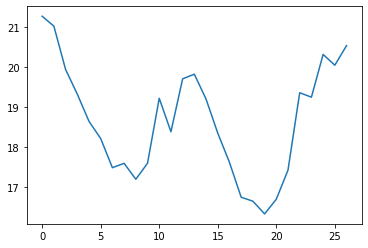

In [20]:
plt.plot(Y_eco_pred_future)

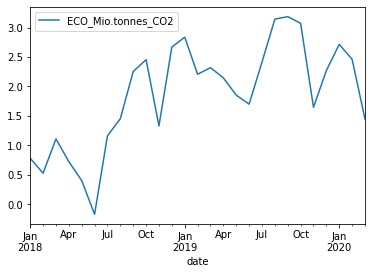

In [21]:
dif=Y_oeko_eco_estimate-Y_eco_pred_future
dif.plot()

###Model 2: Neuronal Network

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 26        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Train on 124 samples, validate on 32 samples
Epoch 1/200
124/124 [==============================] - 0s 934us/step - loss: 243.3803 - mse: 243.3803 - val_loss: 161.7231 - val_mse: 161.7231
Epoch 2/200
124/124 [==============================] - 0s 261us/step - loss: 112.0779 - mse: 112.0779 - val_loss: 54.5412 - val_mse: 54.5412
Epoch 3/200
124/124 [==============================] - 0s 332us/step - loss: 36.5471 - mse: 36.5471 - val_loss: 12.7861 - val_mse: 12.7861
Epoch 4/200
124/124 [==============================]

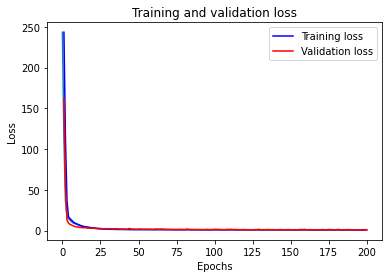

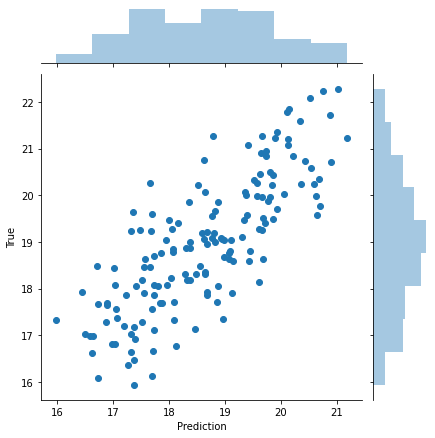

In [22]:
Y_eco_pred_future=my_NeuronalNetwork(X_eco_train,Y_eco_train,X_eco_future)

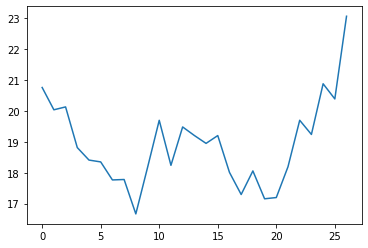

In [23]:
plt.plot(Y_eco_pred_future)

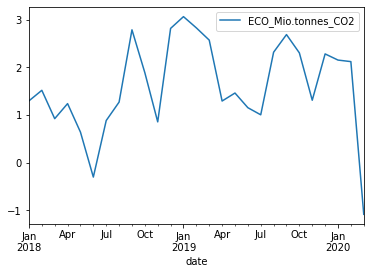

In [24]:
dif=Y_oeko_eco_estimate-Y_eco_pred_future
dif.plot()

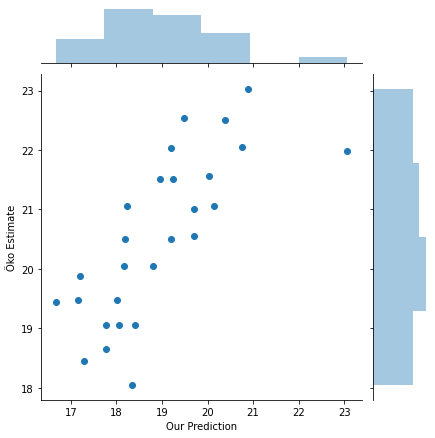

In [25]:
ax = sns.jointplot(x=Y_eco_pred_future,y=Y_oeko_eco_estimate)
ax.ax_joint.set_xlabel('Our Prediction')
ax.ax_joint.set_ylabel('Öko Estimate')
plt.show()

### Model 3: PLSR

Best parameter RMSE=1.018):
{'plsr__n_components': 11}


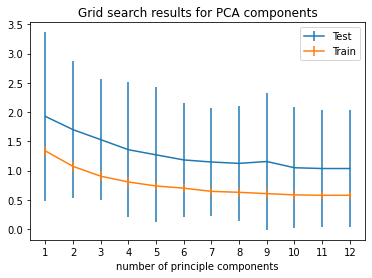

RMSE training fit: 0.772
R2 training fit: 0.709 


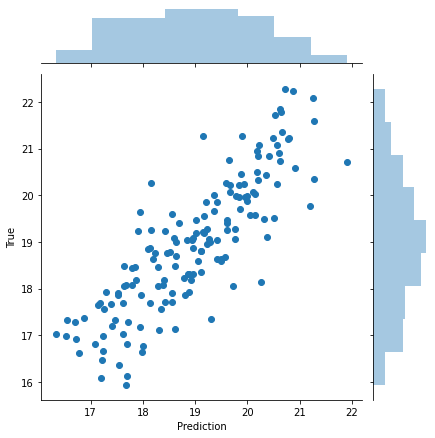

In [26]:
Y_eco_pred_future=my_PLSR(X_eco_train,Y_eco_train,X_eco_future)

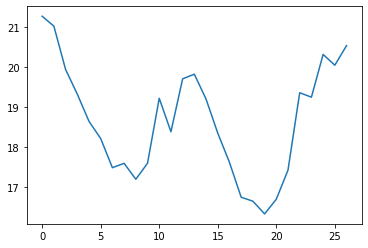

In [27]:
plt.plot(Y_eco_pred_future)

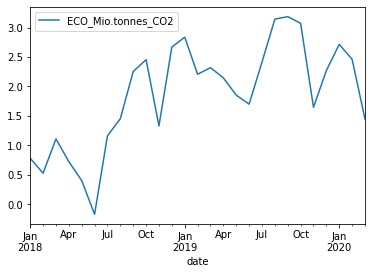

In [28]:
dif=Y_oeko_eco_estimate-Y_eco_pred_future
dif.plot()

### Model 4: LASS0

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.48847481827694, tolerance: 0.031920813364504634
  positive)


Best parameter RMSE=1.018):
{'alpha': 0.0}


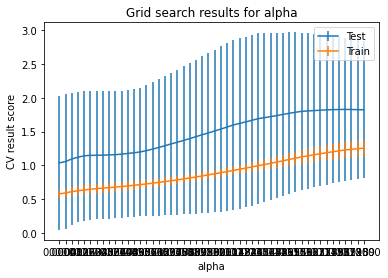

RMSE training fit: 0.772
R2 training fit: 0.709 


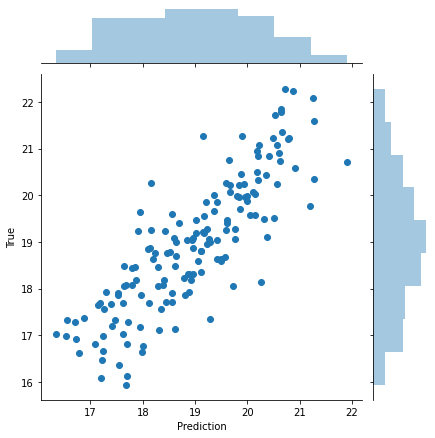

In [29]:
  alphas = np.linspace(0,0.2,50)
  Y_eco_pred_future=my_LASSO(X_eco_train,Y_eco_train,X_eco_future,alphas)

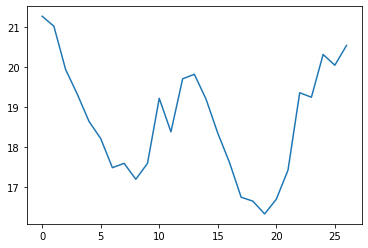

In [30]:
plt.plot(Y_eco_pred_future)

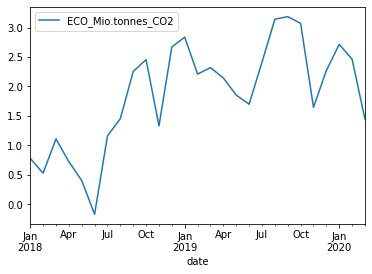

In [31]:
dif=Y_oeko_eco_estimate-Y_eco_pred_future
dif.plot()

###Model 5: Ridge

Best parameter RMSE=1.071):
{'alpha': 5.0}


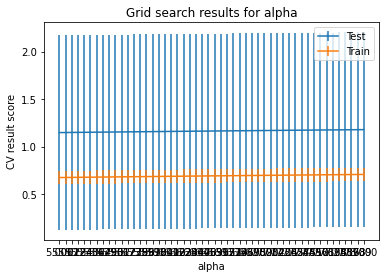

RMSE training fit: 0.829
R2 training fit: 0.664 


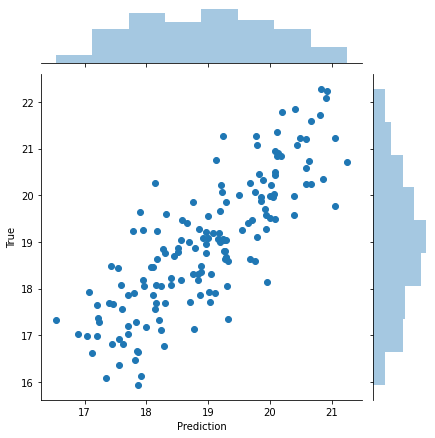

In [32]:
alphas = np.linspace(5,8,50)
Y_eco_pred_future=my_Ridge(X_eco_train,Y_eco_train,X_eco_future,alphas)

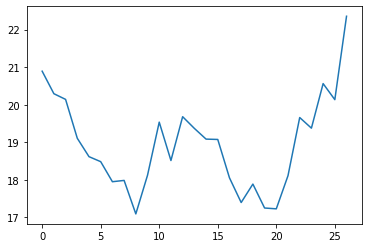

In [33]:
plt.plot(Y_eco_pred_future)

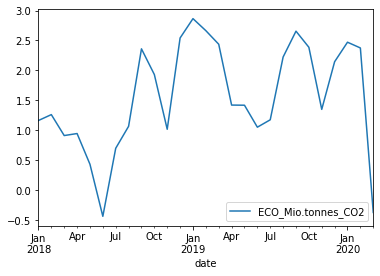

In [34]:
dif=Y_oeko_eco_estimate-Y_eco_pred_future
dif.plot()

##Mobility

In [35]:
Y_mob_train = Y[['M_Mio.tonnes_CO2']][(Y.index >= X_mob_raw.index.min())]

X_mob_train = X_mob_raw[(X_mob_raw.index.year <=2017)]
X_mob_future = X_mob_raw[(X_mob_raw.index.year >2017)]

Y_oeko_mob_estimate = Y_oeko_estimate[['M_Mio.tonnes_CO2']][(Y_oeko_estimate.index <= X_mob_future.index.max())]

###Model 1: Linear/Non-Linear Regression

Best parameter RMSE=0.469):
{'pca__n_components': 1}


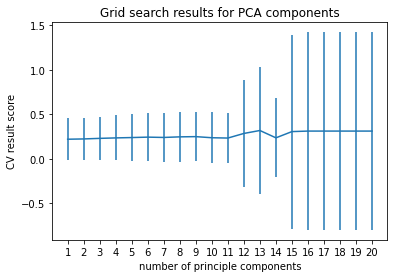

RMSE training fit: 0.457
R2 training fit: 0.715 


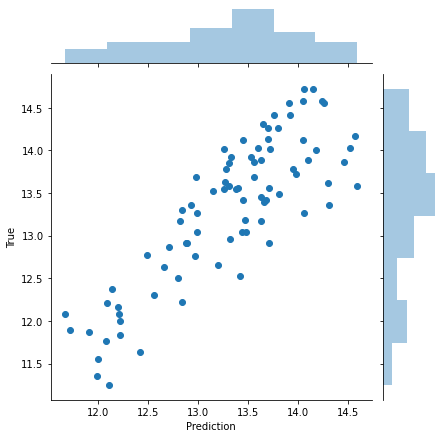

In [36]:
Y_mob_pred_future=my_LinearRegression(X_mob_train,Y_mob_train,X_mob_future,2)

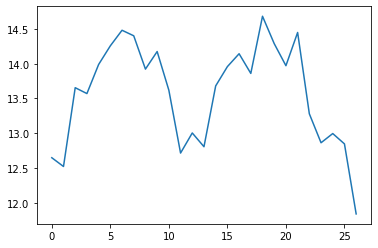

In [37]:
plt.plot(Y_mob_pred_future)

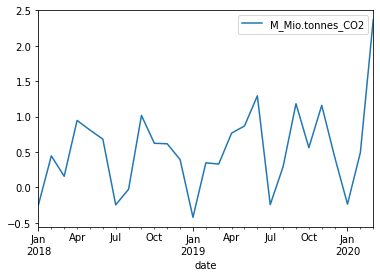

In [38]:
dif=Y_oeko_mob_estimate-Y_mob_pred_future
dif.plot()

###Model 2: Neuronal Network

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 0s 1ms/step - loss: 126.3558 - mse: 126.3558 - val_loss: 75.9890 - val_mse: 75.9890
Epoch 2/200
67/67 [==============================] - 0s 295us/step - loss: 60.7963 - mse: 60.7963 - val_loss: 28.2120 - val_mse: 28.2120
Epoch 3/200
67/67 [==============================] - 0s 271us/step - loss: 22.6939 - mse: 22.6939 - val_loss: 8.1623 - val_mse: 8.1623
Epoch 4/200
67/67 [==============================] - 0s 286us/step 

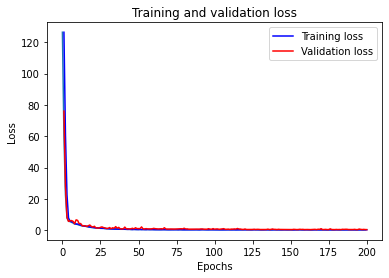

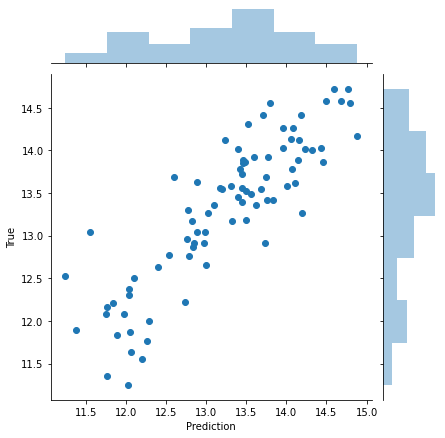

In [39]:
Y_mob_pred_future=my_NeuronalNetwork(X_mob_train,Y_mob_train,X_mob_future)

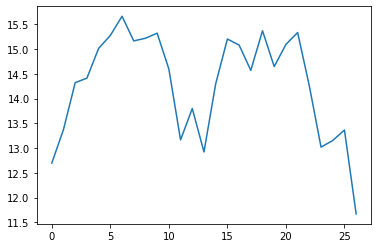

In [40]:
plt.plot(Y_mob_pred_future)

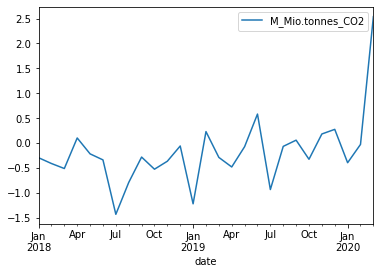

In [41]:
dif=Y_oeko_mob_estimate-Y_mob_pred_future
dif.plot()

### Model 3: PLSR

Best parameter RMSE=0.453):
{'plsr__n_components': 4}


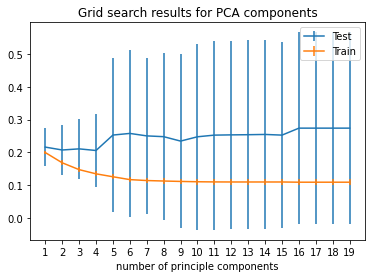

RMSE training fit: 0.370
R2 training fit: 0.813 


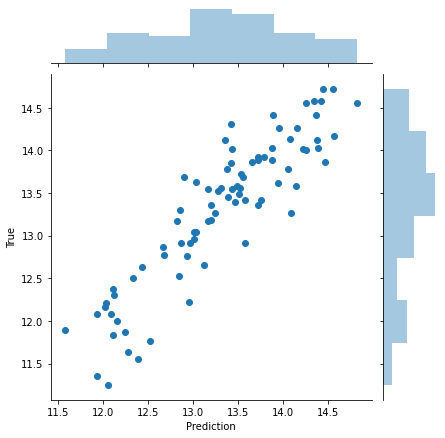

In [42]:
Y_mob_pred_future=my_PLSR(X_mob_train,Y_mob_train,X_mob_future)

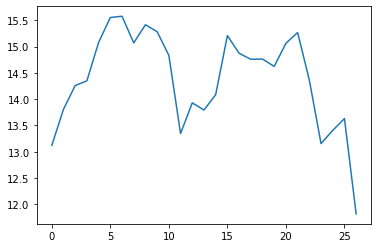

In [43]:
plt.plot(Y_mob_pred_future)

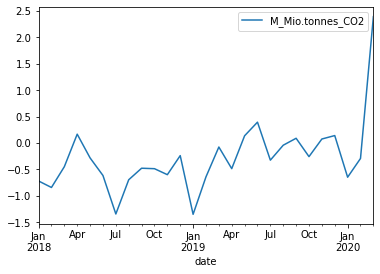

In [44]:
dif=Y_oeko_mob_estimate-Y_mob_pred_future
dif.plot()

### Model 4: LASS0

Best parameter RMSE=0.422):
{'alpha': 0.028571428571428574}


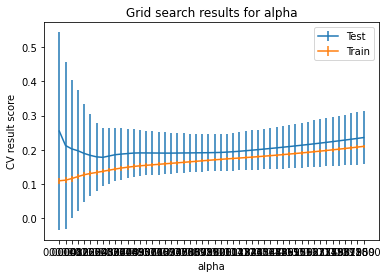

RMSE training fit: 0.372
R2 training fit: 0.811 


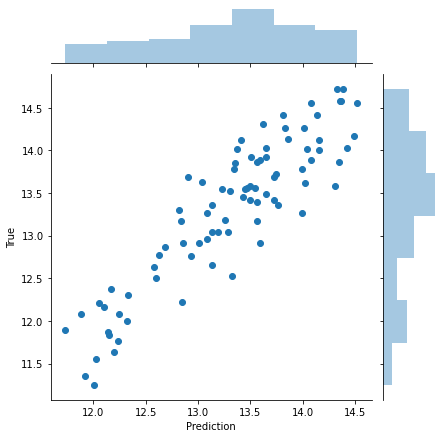

In [45]:
  alphas = np.linspace(0,0.2,50)
  Y_mob_pred_future=my_LASSO(X_mob_train,Y_mob_train,X_mob_future,alphas)

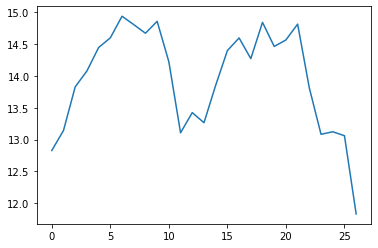

In [46]:
plt.plot(Y_mob_pred_future)

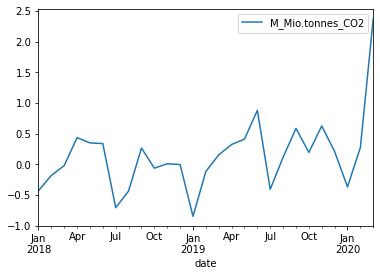

In [47]:
dif=Y_oeko_mob_estimate-Y_mob_pred_future
dif.plot()

###Model 5: Ridge

Best parameter RMSE=0.419):
{'alpha': 6.959183673469388}


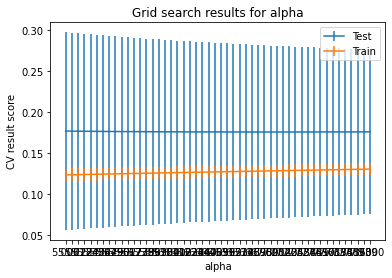

RMSE training fit: 0.359
R2 training fit: 0.824 


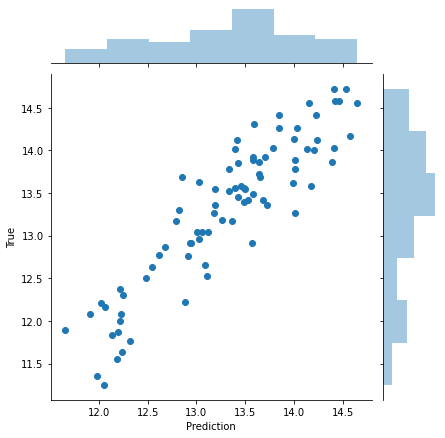

In [48]:
alphas = np.linspace(5,8,50)
Y_mob_pred_future=my_Ridge(X_mob_train,Y_mob_train,X_mob_future,alphas)

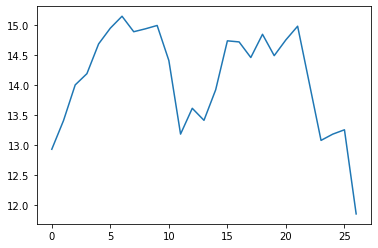

In [49]:
plt.plot(Y_mob_pred_future)

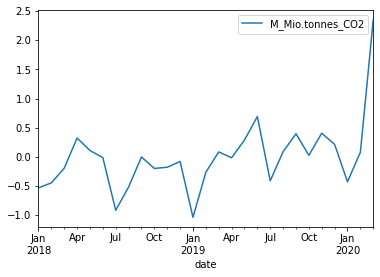

In [50]:
dif=Y_oeko_mob_estimate-Y_mob_pred_future
dif.plot()

##Energy and Households

In [51]:
Y_eh_train = Y[['E_Mio.tonnes_CO2']][(Y.index >= X_eh_raw.index.min())]

X_eh_train = X_eh_raw[(X_eh_raw.index.year <=2017)]
X_eh_future = X_eh_raw[(X_eh_raw.index.year >2017)]

Y_oeko_eh_estimate = Y_oeko_estimate[['E_Mio.tonnes_CO2']][(Y_oeko_estimate.index <= X_eh_future.index.max())]

###Model 1: Linear/Non-Linear Regression

Best parameter RMSE=1.545):
{'pca__n_components': 9}


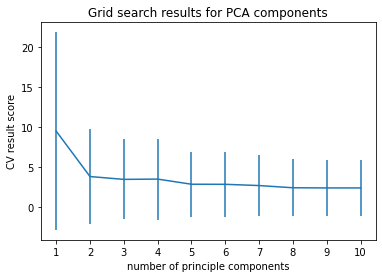

RMSE training fit: 1.421
R2 training fit: 0.920 


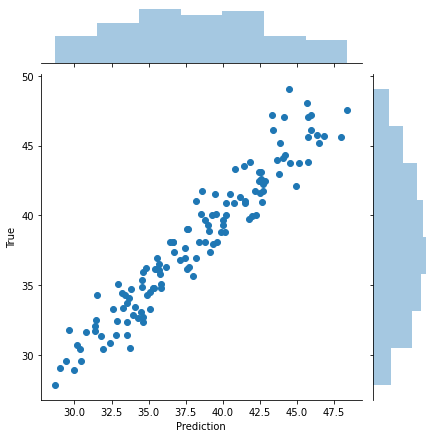

In [52]:
Y_eh_pred_future=my_LinearRegression(X_eh_train,Y_eh_train,X_eh_future,2)

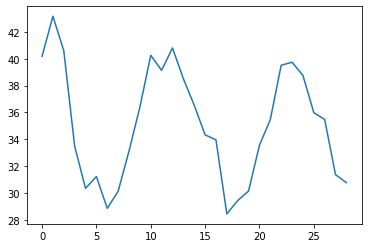

In [53]:
plt.plot(Y_eh_pred_future)

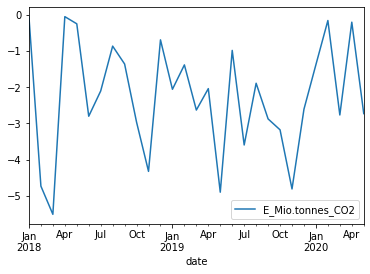

In [54]:
dif=Y_oeko_eh_estimate-Y_eh_pred_future
dif.plot()

###Model 2: Neuronal Network

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________
Train on 104 samples, validate on 26 samples
Epoch 1/200
104/104 [==============================] - 0s 781us/step - loss: 1503.8086 - mse: 1503.8085 - val_loss: 1332.2955 - val_mse: 1332.2957
Epoch 2/200
104/104 [==============================] - 0s 270us/step - loss: 1481.6174 - mse: 1481.6173 - val_loss: 1316.6740 - val_mse: 1316.6740
Epoch 3/200
104/104 [==============================] - 0s 345us/step - loss: 1465.4998 - mse: 1465.4998 - val_loss: 1301.7066 - val_mse: 1301.7065
Epoch 4/200
104/104 [=============

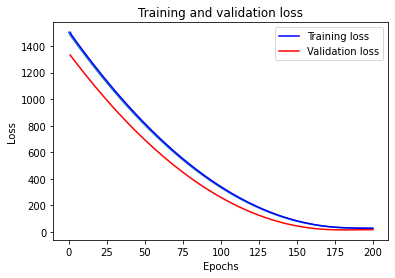

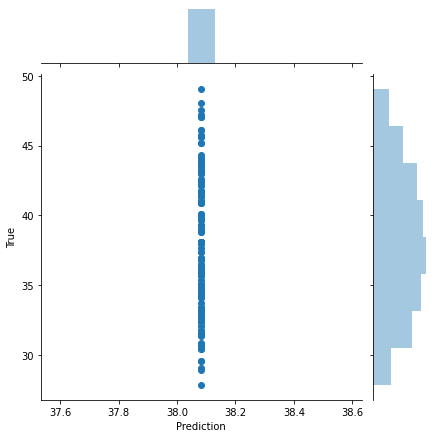

In [55]:
Y_eh_pred_future=my_NeuronalNetwork(X_eh_train,Y_eh_train,X_eh_future)

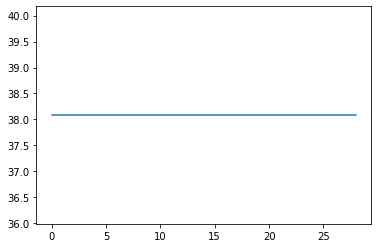

In [56]:
plt.plot(Y_eh_pred_future)

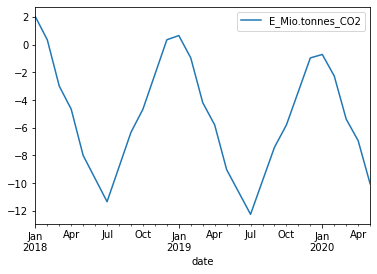

In [57]:
dif=Y_oeko_eh_estimate-Y_eh_pred_future
dif.plot()

### Model 3: PLSR

Best parameter RMSE=1.619):
{'plsr__n_components': 5}


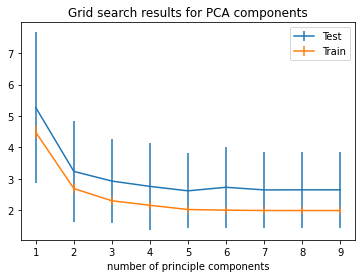

RMSE training fit: 1.431
R2 training fit: 0.919 


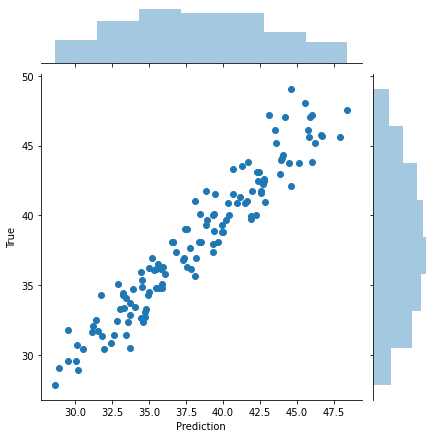

In [58]:
Y_eh_pred_future=my_PLSR(X_eh_train,Y_eh_train,X_eh_future)

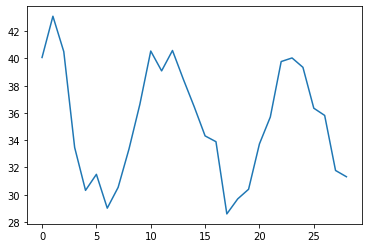

In [59]:
plt.plot(Y_eh_pred_future)

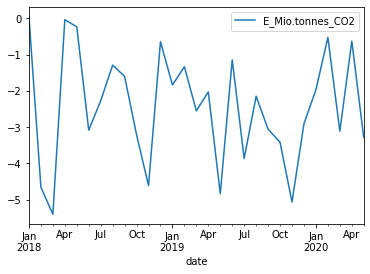

In [60]:
dif=Y_oeko_eh_estimate-Y_eh_pred_future
dif.plot()

### Model 4: LASS0

Best parameter RMSE=1.621):
{'alpha': 0.0489795918367347}


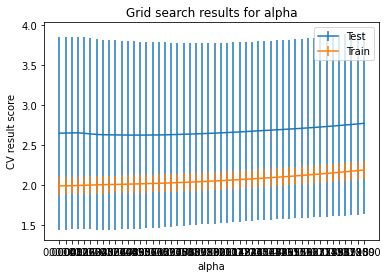

RMSE training fit: 1.429
R2 training fit: 0.919 


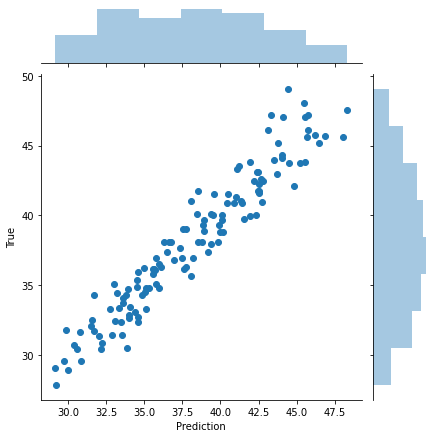

In [61]:
  alphas = np.linspace(0,0.2,50)
  Y_eh_pred_future=my_LASSO(X_eh_train,Y_eh_train,X_eh_future,alphas)

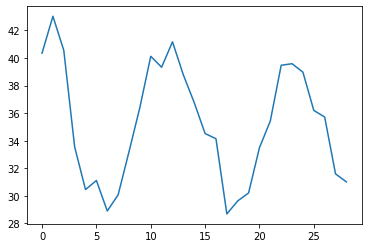

In [62]:
plt.plot(Y_eh_pred_future)

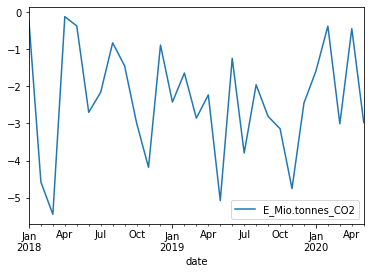

In [63]:
dif=Y_oeko_eh_estimate-Y_eh_pred_future
dif.plot()

###Model 5: Ridge

Best parameter RMSE=1.624):
{'alpha': 5.0}


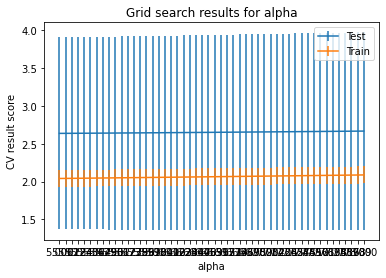

RMSE training fit: 1.436
R2 training fit: 0.919 


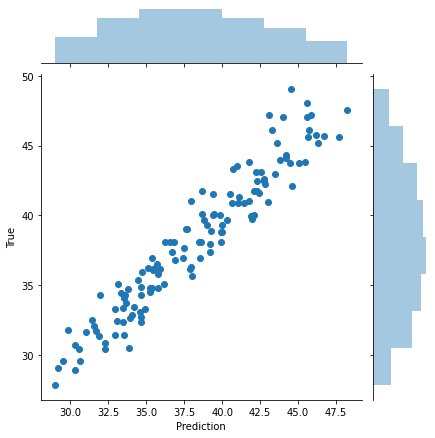

In [64]:
alphas = np.linspace(5,8,50)
Y_eh_pred_future=my_Ridge(X_eh_train,Y_eh_train,X_eh_future,alphas)

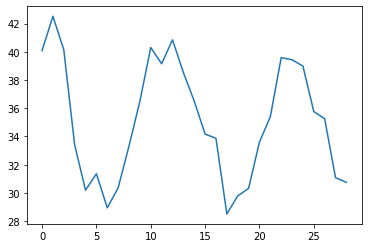

In [65]:
plt.plot(Y_eh_pred_future)

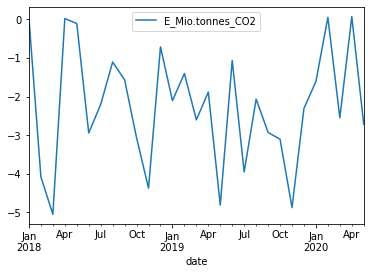

In [66]:
dif=Y_oeko_eh_estimate-Y_eh_pred_future
dif.plot()